In [54]:
!pip install roboflow


In [55]:
from roboflow import Roboflow

# Replace with your API key from https://roboflow.com
rf = Roboflow(api_key="WAaH20T215gOBr8ygApN")

project = rf.workspace("fct-wound-ai").project("woundcare-opensource-dataset")
dataset = project.version(1).download("yolov8")

print("Dataset downloaded to:", dataset.location)


loading Roboflow workspace...
loading Roboflow project...
Dataset downloaded to: /content/WoundCare-Opensource-Dataset-1


In [56]:
import os

folders = [
    "data/raw/woundcare",
    "data/raw/skinburn",
    "data/unified/images",
    "data/unified/labels"
]

for folder in folders:
    os.makedirs(folder, exist_ok=True)

print("Folder structure ready.")


Folder structure ready.


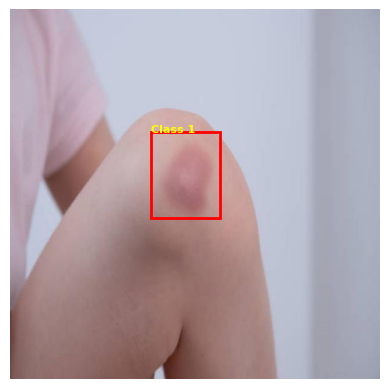

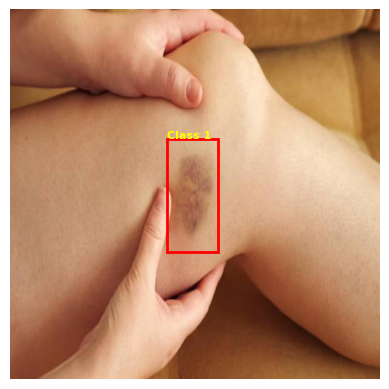

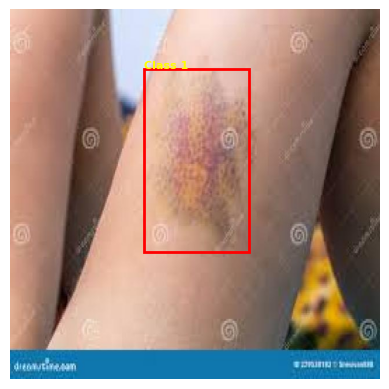

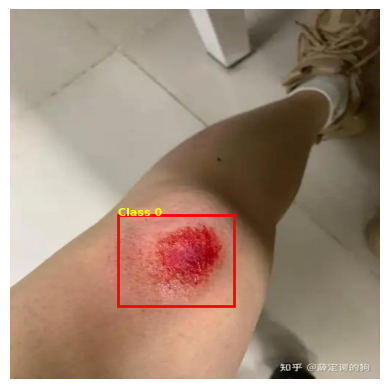

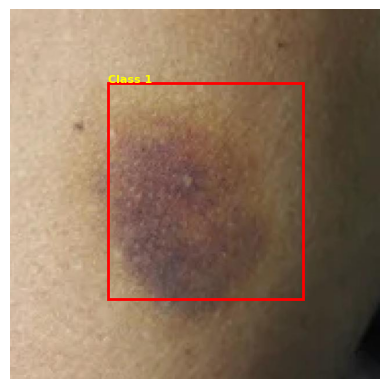

In [57]:
import glob
import os
import cv2
import matplotlib.pyplot as plt

# Function to show image with bounding boxes
def show_image_with_boxes(img_path, label_path):
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    fig, ax = plt.subplots(1)
    ax.imshow(img)

    with open(label_path, "r") as f:
        for line in f:
            cls_id, x_c, y_c, bw, bh = map(float, line.strip().split())
            x = (x_c - bw/2) * w
            y = (y_c - bh/2) * h
            rect = plt.Rectangle((x, y), bw*w, bh*h,
                                 linewidth=2, edgecolor="r", facecolor="none")
            ax.add_patch(rect)
            ax.text(x, y, f"Class {int(cls_id)}",
                    color="yellow", fontsize=8, weight="bold")

    plt.axis("off")
    plt.show()

# Automatically pick first 5 images & labels from Roboflow dataset
images_path = glob.glob("WoundCare-Opensource-Dataset-1/train/images/*.jpg")
labels_path = "WoundCare-Opensource-Dataset-1/train/labels/"

for img_file in images_path[:5]:
    label_file = os.path.join(labels_path, os.path.basename(img_file).replace(".jpg", ".txt"))
    show_image_with_boxes(img_file, label_file)



In [58]:
from roboflow import Roboflow

rf = Roboflow(api_key="WAaH20T215gOBr8ygApN")
project_sb = rf.workspace("sakarya-university").project("skin-burn-s7nan")
dataset_sb = project_sb.version(2).download("yolov8")  # version v2: ~1,828 images


loading Roboflow workspace...
loading Roboflow project...


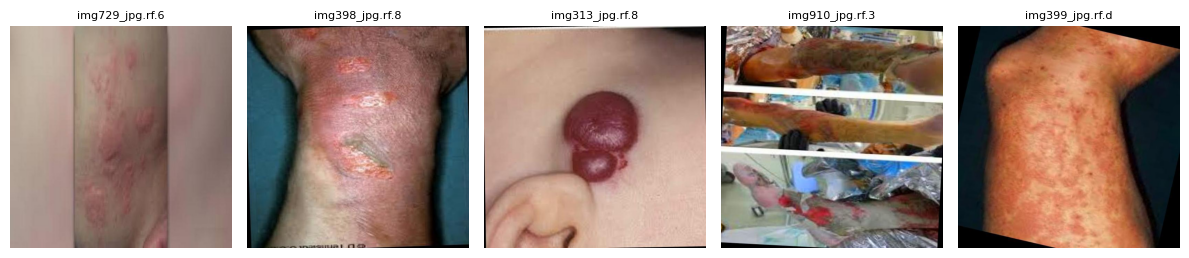

In [59]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Path to Skin Burn train images
sb_images_path = "/content/Skin-Burn-2/train/images"

# List the first 5 image filenames
sample_files = os.listdir(sb_images_path)[:5]

# Display them
plt.figure(figsize=(12, 6))
for idx, file in enumerate(sample_files):
    img_path = os.path.join(sb_images_path, file)
    img = Image.open(img_path)
    plt.subplot(1, len(sample_files), idx + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(file[:15], fontsize=8)

plt.tight_layout()
plt.show()



In [60]:
import os
import shutil

# Paths to your datasets
woundcare_path = "/content/WoundCare-Opensource-1"   # update if different
skinburn_path = "/content/Skin-Burn-2"
merged_path = "/content/merged_dataset"

# Create unified folders
for split in ["train", "valid", "test"]:
    os.makedirs(os.path.join(merged_path, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(merged_path, split, "labels"), exist_ok=True)

def merge_split(split, src_path):
    img_src = os.path.join(src_path, split, "images")
    lbl_src = os.path.join(src_path, split, "labels")
    img_dst = os.path.join(merged_path, split, "images")
    lbl_dst = os.path.join(merged_path, split, "labels")

    if os.path.exists(img_src):
        for file in os.listdir(img_src):
            shutil.copy(os.path.join(img_src, file), os.path.join(img_dst, f"{src_path.split('/')[-1]}_{file}"))

    if os.path.exists(lbl_src):
        for file in os.listdir(lbl_src):
            shutil.copy(os.path.join(lbl_src, file), os.path.join(lbl_dst, f"{src_path.split('/')[-1]}_{file}"))

# Merge WoundCare + Skin Burn for each split
for split in ["train", "valid", "test"]:
    merge_split(split, woundcare_path)
    merge_split(split, skinburn_path)

print("✅ Datasets merged into:", merged_path)


✅ Datasets merged into: /content/merged_dataset


In [61]:
import os

base_path = "data/raw"  # or wherever you store datasets
for root, dirs, files in os.walk(base_path):
    if "images" in dirs:
        print(os.path.join(root, "images"))


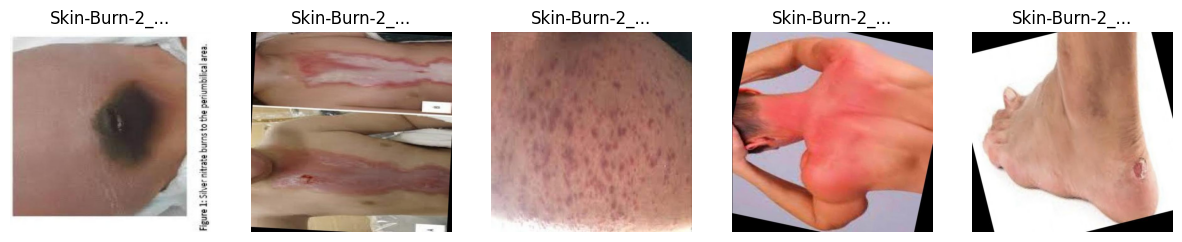

In [62]:
import os
import matplotlib.pyplot as plt
import cv2

merged_path = "/content/merged_dataset"
sample_images = []

# grab a few from train/images
train_images_path = os.path.join(merged_path, "train", "images")
if os.path.exists(train_images_path):
    sample_images = [os.path.join(train_images_path, f) for f in os.listdir(train_images_path)[:5]]

# plot them
plt.figure(figsize=(15, 6))
for i, img_path in enumerate(sample_images):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, len(sample_images), i + 1)
    plt.imshow(img)
    plt.title(os.path.basename(img_path)[:12] + "...")
    plt.axis("off")

plt.show()


In [63]:
import os
from PIL import Image

merged_path = "/content/merged_dataset"

def is_image_valid(img_path):
    try:
        with Image.open(img_path) as img:
            img.verify()  # Will raise if image is corrupted
        return True
    except Exception:
        return False

def clean_dataset(base_path):
    removed_images = 0
    removed_labels = 0
    removed_empty_labels = 0

    for split in ["train", "valid", "test"]:
        img_dir = os.path.join(base_path, split, "images")
        lbl_dir = os.path.join(base_path, split, "labels")

        if not os.path.exists(img_dir) or not os.path.exists(lbl_dir):
            print(f"[WARN] Missing {img_dir} or {lbl_dir}, skipping...")
            continue

        img_files = set(os.listdir(img_dir))
        lbl_files = set(os.listdir(lbl_dir))

        # Check images for corruption
        for img_file in list(img_files):
            img_path = os.path.join(img_dir, img_file)
            if not is_image_valid(img_path):
                print(f"❌ Corrupted image removed: {img_path}")
                os.remove(img_path)
                img_files.remove(img_file)
                removed_images += 1

        # Match labels to images, remove orphan labels
        for lbl_file in list(lbl_files):
            lbl_path = os.path.join(lbl_dir, lbl_file)
            corresponding_img = lbl_file.rsplit(".", 1)[0] + ".jpg"
            if corresponding_img not in img_files:
                print(f"❌ Orphan label removed: {lbl_path}")
                os.remove(lbl_path)
                lbl_files.remove(lbl_file)
                removed_labels += 1
            else:
                # Check for empty labels
                if os.path.getsize(lbl_path) == 0:
                    print(f"❌ Empty label removed: {lbl_path}")
                    os.remove(lbl_path)
                    removed_empty_labels += 1

    print(f"\n🧹 Cleanup done!")
    print(f"Removed {removed_images} corrupted images")
    print(f"Removed {removed_labels} orphan labels")
    print(f"Removed {removed_empty_labels} empty labels")

clean_dataset(merged_path)



🧹 Cleanup done!
Removed 0 corrupted images
Removed 0 orphan labels
Removed 0 empty labels


In [64]:
!git clone https://github.com/uwm-bigdata/wound-segmentation.git


fatal: destination path 'wound-segmentation' already exists and is not an empty directory.


In [65]:
!ls wound-segmentation/data


'Foot Ulcer Segmentation Challenge'   Medetec_foot_ulcer_224   wound_dataset


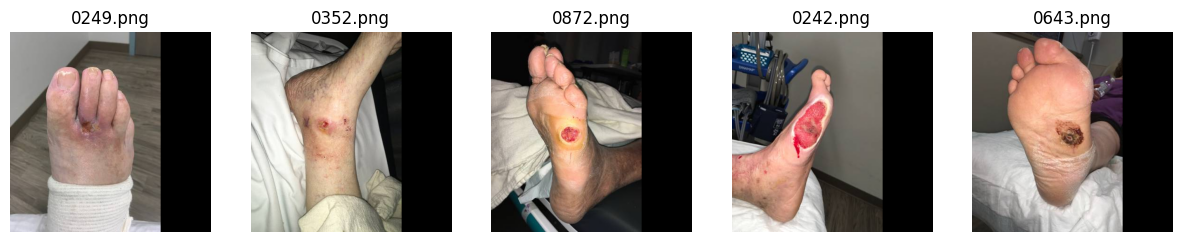

In [66]:
import os
from PIL import Image
import matplotlib.pyplot as plt

data_dir = "wound-segmentation/data/Foot Ulcer Segmentation Challenge/train/images"  # example path, update if needed

sample_files = os.listdir(data_dir)[:5]

plt.figure(figsize=(15,6))
for i, fname in enumerate(sample_files):
    img_path = os.path.join(data_dir, fname)
    img = Image.open(img_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(fname)
plt.show()


In [67]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class WoundSegDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.images = sorted(os.listdir(images_dir))
        self.masks = sorted(os.listdir(masks_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        mask_path = os.path.join(self.masks_dir, self.masks[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # grayscale mask

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask


In [68]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

train_dataset = WoundSegDataset(
    images_dir="wound-segmentation/data/Foot Ulcer Segmentation Challenge/train/images",
    masks_dir="wound-segmentation/data/Foot Ulcer Segmentation Challenge/train/labels",
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)


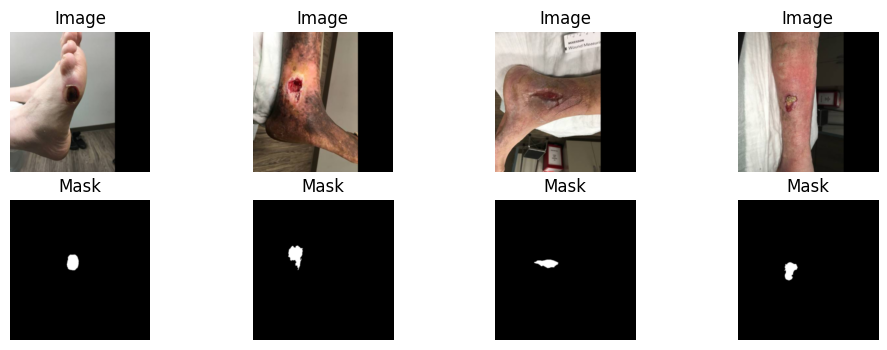

In [69]:

import matplotlib.pyplot as plt

def show_batch(images, masks):
    batch_size = images.size(0)
    plt.figure(figsize=(12, 4))
    for i in range(min(batch_size, 4)):
        plt.subplot(2, 4, i+1)
        plt.imshow(images[i].permute(1, 2, 0))
        plt.title("Image")
        plt.axis('off')

        plt.subplot(2, 4, i+5)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title("Mask")
        plt.axis('off')
    plt.show()

images, masks = next(iter(train_loader))
show_batch(images, masks)


Image shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([1, 256, 256])


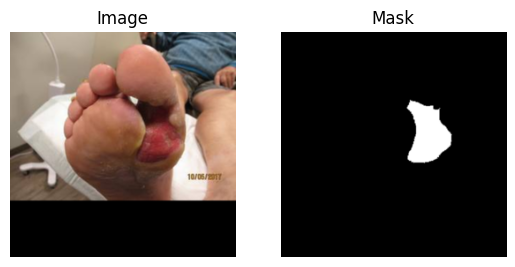

In [70]:
# Assuming your Dataset class from before is defined

dataset = WoundSegDataset(
    images_dir="wound-segmentation/data/Foot Ulcer Segmentation Challenge/train/images",
    masks_dir="wound-segmentation/data/Foot Ulcer Segmentation Challenge/train/labels",
    transform=transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
)

# Get a single sample
image, mask = dataset[0]

print(f"Image shape: {image.shape}")
print(f"Mask shape: {mask.shape}")

# Show the image and mask
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0))  # CHW to HWC
plt.title("Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask.squeeze(), cmap="gray")  # remove channel dim for grayscale
plt.title("Mask")
plt.axis("off")

plt.show()


📦 Dataset: /content/woundcare-opensource-dataset/train → Found 0 images, 0 labels
📦 Dataset: /content/Skin-Burn-2/train → Found 1899 images, 1899 labels
📦 Dataset: /content/wound-segmentation/data/wound_dataset → Found 0 images, 0 labels

✅ Auto-merge complete! Now peeking...


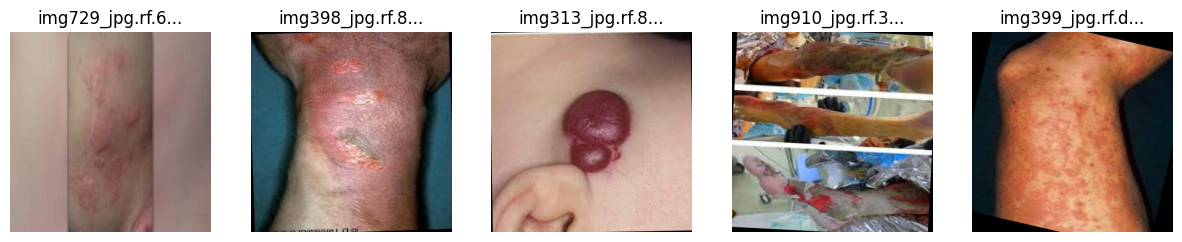

In [71]:
import os
import glob
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def auto_detect_merge_and_peek(dataset_dirs, target_img_dir, target_label_dir, img_exts=(".png", ".jpg", ".jpeg"), peek_count=5):
    os.makedirs(target_img_dir, exist_ok=True)
    os.makedirs(target_label_dir, exist_ok=True)

    for dataset_dir in dataset_dirs:
        # Detect images
        img_files = []
        for ext in img_exts:
            img_files.extend(glob.glob(os.path.join(dataset_dir, "**", f"*{ext}"), recursive=True))

        # Detect labels (txt / json / xml)
        label_files = []
        for ext in (".txt", ".json", ".xml"):
            label_files.extend(glob.glob(os.path.join(dataset_dir, "**", f"*{ext}"), recursive=True))

        print(f"📦 Dataset: {dataset_dir} → Found {len(img_files)} images, {len(label_files)} labels")

        # Copy images
        for img_path in img_files:
            shutil.copy(img_path, os.path.join(target_img_dir, os.path.basename(img_path)))

        # Copy labels
        for label_path in label_files:
            shutil.copy(label_path, os.path.join(target_label_dir, os.path.basename(label_path)))

    print("\n✅ Auto-merge complete! Now peeking...")

    # Peek at some images
    merged_images = glob.glob(os.path.join(target_img_dir, "*"))
    plt.figure(figsize=(15, 6))
    for i, img_path in enumerate(merged_images[:peek_count]):
        plt.subplot(1, peek_count, i+1)
        img = mpimg.imread(img_path)
        plt.imshow(img)
        plt.axis('off')
        plt.title(os.path.basename(img_path)[:15] + "...")
    plt.show()


# Example usage
source_dirs = [
    "/content/woundcare-opensource-dataset/train",   # woundcare dataset
    "/content/Skin-Burn-2/train",                    # skin burn dataset
    "/content/wound-segmentation/data/wound_dataset" # foot ulcer etc.
]

target_img_dir = "/content/project_root/data/images/train"
target_label_dir = "/content/project_root/data/labels/train"

auto_detect_merge_and_peek(source_dirs, target_img_dir, target_label_dir)


In [72]:
import os
from PIL import Image

def cleanup_dataset(images_dir, labels_dir):
    removed_count = 0

    for img_file in os.listdir(images_dir):
        img_path = os.path.join(images_dir, img_file)
        label_path = os.path.join(labels_dir, os.path.splitext(img_file)[0] + ".txt")

        # Remove if label missing
        if not os.path.exists(label_path):
            os.remove(img_path)
            removed_count += 1
            continue

        # Remove if image corrupted
        try:
            with Image.open(img_path) as img:
                img.verify()
        except:
            os.remove(img_path)
            if os.path.exists(label_path):
                os.remove(label_path)
            removed_count += 1

    total_images = len(os.listdir(images_dir))
    total_labels = len(os.listdir(labels_dir))

    print(f"✅ Cleanup complete!")
    print(f"🗑️ Removed {removed_count} bad samples.")
    print(f"📊 Remaining: {total_images} images | {total_labels} labels")

# Example: paths for ComplexWoundDB in our unified dataset
images_dir = "project_root/data/images/train"
labels_dir = "project_root/data/labels/train"

cleanup_dataset(images_dir, labels_dir)


✅ Cleanup complete!
🗑️ Removed 0 bad samples.
📊 Remaining: 1899 images | 1899 labels


In [73]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Create your project folder
base_path = "/content/drive/MyDrive/wound_project/raw"
os.makedirs(base_path, exist_ok=True)
print(f"Base path: {base_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Base path: /content/drive/MyDrive/wound_project/raw


In [74]:
# Move files from /content (temporary) to Drive (permanent)
!mv /content/WoundTissue-main.zip "{base_path}/WoundTissue-main.zip"
!mv /content/results.zip "{base_path}/results.zip"
!mv /content/description.csv "{base_path}/description.csv"


mv: cannot stat '/content/WoundTissue-main.zip': No such file or directory
mv: cannot stat '/content/results.zip': No such file or directory
mv: cannot stat '/content/description.csv': No such file or directory


In [76]:
import zipfile
import shutil

def unzip_to(src, dest):
    os.makedirs(dest, exist_ok=True)
    with zipfile.ZipFile(src, 'r') as zip_ref:
        zip_ref.extractall(dest)
    print(f"Extracted {src} → {dest}")

# Paths in Drive
woundtissue_zip = f"{base_path}/WoundTissue-main.zip"
woundsdb_processed_zip = f"{base_path}/results.zip"
woundsdb_desc_csv = f"{base_path}/description.csv"

# Destination folders
woundtissue_path = f"{base_path}/woundtissue"
woundsdb_processed_path = f"{base_path}/woundsdb/processed"
woundsdb_description_path = f"{base_path}/woundsdb/description"

# Extract datasets
unzip_to(woundtissue_zip, woundtissue_path)
unzip_to(woundsdb_processed_zip, woundsdb_processed_path)

# Move description CSV into its folder
os.makedirs(woundsdb_description_path, exist_ok=True)
shutil.copy(woundsdb_desc_csv, os.path.join(woundsdb_description_path, "description.csv"))
print(f"Copied description.csv → {woundsdb_description_path}")


Extracted /content/drive/MyDrive/wound_project/raw/WoundTissue-main.zip → /content/drive/MyDrive/wound_project/raw/woundtissue


OSError: [Errno 22] Invalid argument

In [77]:
import os
import pandas as pd

def peek_dir(path, n=5):
    if not os.path.exists(path):
        print(f"❌ Path not found: {path}")
        return
    files = os.listdir(path)
    print(f"📂 {path} — {len(files)} files")
    if files:
        print("First few files:", files[:n])
    else:
        print("⚠️ Folder is empty!")
    print("-" * 50)

# Paths
woundtissue_path = "/content/drive/MyDrive/wound_project/raw/woundtissue"
woundsdb_processed_path = "/content/drive/MyDrive/wound_project/raw/woundsdb/processed"
woundsdb_description_path = "/content/drive/MyDrive/wound_project/raw/woundsdb/description/description.csv"

# Peek into image folders
peek_dir(woundtissue_path)
peek_dir(woundsdb_processed_path)

# Check description CSV
if os.path.exists(woundsdb_description_path):
    df = pd.read_csv(woundsdb_description_path)
    print(f"📝 {woundsdb_description_path} — {len(df)} rows, {len(df.columns)} columns")
    print(df.head())
else:
    print(f"❌ Description CSV not found at {woundsdb_description_path}")


📂 /content/drive/MyDrive/wound_project/raw/woundtissue — 1 files
First few files: ['WoundTissue-main']
--------------------------------------------------
📂 /content/drive/MyDrive/wound_project/raw/woundsdb/processed — 1 files
First few files: ['results']
--------------------------------------------------
📝 /content/drive/MyDrive/wound_project/raw/woundsdb/description/description.csv — 188 rows, 15 columns
                         Path to files  Age [year] Sex  \
0   patients\case_1\day_1\data\scene_1        82.0   m   
1  patients\case_10\day_1\data\scene_1        50.0   f   
2  patients\case_10\day_1\data\scene_2        50.0   f   
3  patients\case_11\day_1\data\scene_1        67.0   f   
4  patients\case_11\day_1\data\scene_2        67.0   f   

                             Treatment technique       Wound aetiology  \
0  Modern wound dressing and compression therapy         Venous ulcers   
1                          Modern wound dressing            Mastectomy   
2                   

In [78]:
import os
import pandas as pd

# Paths
base_dir = "/content/drive/MyDrive/wound_project/raw/woundsdb/processed"
desc_path = "/content/drive/MyDrive/wound_project/raw/woundsdb/description/description.csv"

# Load description.csv
df = pd.read_csv(desc_path)

missing_files = []

# Iterate over rows
for _, row in df.iterrows():
    rel_path = row["Path to files"].replace("\\", "/")  # Windows → Unix paths
    full_dir = os.path.join(base_dir, rel_path)

    # Check Photo
    if row["Photo"] == 1:
        photo_path = os.path.join(full_dir, "photo.jpg")
        if not os.path.exists(photo_path):
            missing_files.append(photo_path)

    # Check Mask
    if row["Mask"] == 1:
        mask_path = os.path.join(full_dir, "mask.png")
        if not os.path.exists(mask_path):
            missing_files.append(mask_path)

print(f"Total missing files: {len(missing_files)}")
if missing_files:
    print("Example missing files:", missing_files[:10])
else:
    print("✅ All referenced files exist!")


Total missing files: 376
Example missing files: ['/content/drive/MyDrive/wound_project/raw/woundsdb/processed/patients/case_1/day_1/data/scene_1/photo.jpg', '/content/drive/MyDrive/wound_project/raw/woundsdb/processed/patients/case_1/day_1/data/scene_1/mask.png', '/content/drive/MyDrive/wound_project/raw/woundsdb/processed/patients/case_10/day_1/data/scene_1/photo.jpg', '/content/drive/MyDrive/wound_project/raw/woundsdb/processed/patients/case_10/day_1/data/scene_1/mask.png', '/content/drive/MyDrive/wound_project/raw/woundsdb/processed/patients/case_10/day_1/data/scene_2/photo.jpg', '/content/drive/MyDrive/wound_project/raw/woundsdb/processed/patients/case_10/day_1/data/scene_2/mask.png', '/content/drive/MyDrive/wound_project/raw/woundsdb/processed/patients/case_11/day_1/data/scene_1/photo.jpg', '/content/drive/MyDrive/wound_project/raw/woundsdb/processed/patients/case_11/day_1/data/scene_1/mask.png', '/content/drive/MyDrive/wound_project/raw/woundsdb/processed/patients/case_11/day_1/d

In [79]:
import os
import pandas as pd

# Paths
woundtissue_path = "/content/drive/MyDrive/wound_project/raw/woundtissue"
woundsdb_processed_path = "/content/drive/MyDrive/wound_project/raw/woundsdb/processed"
woundsdb_description_csv = "/content/drive/MyDrive/wound_project/raw/woundsdb/description/description.csv"

# --- 1) WoundsDB check ---
desc_df = pd.read_csv(woundsdb_description_csv)

# Normalize CSV paths (replace backslashes with forward slashes)
desc_df['Path to files'] = desc_df['Path to files'].str.replace("\\", "/")

expected_files = []
for base in desc_df['Path to files']:
    expected_files.append(os.path.join(woundsdb_processed_path, base, "photo.jpg"))
    expected_files.append(os.path.join(woundsdb_processed_path, base, "mask.png"))

missing_files = [f for f in expected_files if not os.path.exists(f)]
extra_files = []
for root, _, files in os.walk(woundsdb_processed_path):
    for file in files:
        full_path = os.path.join(root, file)
        rel_path = os.path.relpath(full_path, woundsdb_processed_path)
        if full_path not in expected_files:
            extra_files.append(rel_path)

print("📂 WoundsDB Check:")
print(f"  Missing files: {len(missing_files)}")
print(f"  Extra files: {len(extra_files)}")
if missing_files:
    print("  Example missing:", missing_files[:5])

# --- 2) WoundTissue check ---
tissue_files = []
for root, _, files in os.walk(woundtissue_path):
    for file in files:
        tissue_files.append(os.path.join(root, file))

print("\n📂 WoundTissue Check:")
print(f"  Total files: {len(tissue_files)}")
if len(tissue_files) == 0:
    print("  ❌ No files found — extraction may have failed")
else:
    print("  ✅ Files are present")

# --- 3) CSV presence ---
print("\n📂 CSV Check:")
if os.path.exists(woundsdb_description_csv):
    print("  ✅ description.csv found")
    print(f"  Rows: {len(desc_df)}, Columns: {len(desc_df.columns)}")
else:
    print("  ❌ description.csv missing")


📂 WoundsDB Check:
  Missing files: 376
  Extra files: 814
  Example missing: ['/content/drive/MyDrive/wound_project/raw/woundsdb/processed/patients/case_1/day_1/data/scene_1/photo.jpg', '/content/drive/MyDrive/wound_project/raw/woundsdb/processed/patients/case_1/day_1/data/scene_1/mask.png', '/content/drive/MyDrive/wound_project/raw/woundsdb/processed/patients/case_10/day_1/data/scene_1/photo.jpg', '/content/drive/MyDrive/wound_project/raw/woundsdb/processed/patients/case_10/day_1/data/scene_1/mask.png', '/content/drive/MyDrive/wound_project/raw/woundsdb/processed/patients/case_10/day_1/data/scene_2/photo.jpg']

📂 WoundTissue Check:
  Total files: 31
  ✅ Files are present

📂 CSV Check:
  ✅ description.csv found
  Rows: 188, Columns: 15


In [80]:
import pandas as pd
import os

# Paths
woundsdb_desc_path = "/content/drive/MyDrive/wound_project/raw/woundsdb/description/description.csv"
woundsdb_proc_path = "/content/drive/MyDrive/wound_project/raw/woundsdb/processed"
woundtissue_path = "/content/drive/MyDrive/wound_project/raw/woundtissue"

# Output folder
processed_dir = "/content/drive/MyDrive/wound_project/processed"
os.makedirs(processed_dir, exist_ok=True)

# --- Load WoundsDB metadata ---
df_woundsdb = pd.read_csv(woundsdb_desc_path)

# Normalize paths (convert \ to /)
df_woundsdb['Path to files'] = df_woundsdb['Path to files'].str.replace("\\", "/", regex=False)

# Make full paths for important files
df_woundsdb['photo_path'] = df_woundsdb['Path to files'].apply(
    lambda x: os.path.join(woundsdb_proc_path, x, "photo.jpg")
)
df_woundsdb['mask_path'] = df_woundsdb['Path to files'].apply(
    lambda x: os.path.join(woundsdb_proc_path, x, "mask.png")
)

# Keep only existing files
df_woundsdb = df_woundsdb[
    df_woundsdb['photo_path'].apply(os.path.exists) &
    df_woundsdb['mask_path'].apply(os.path.exists)
]

# Add dataset name
df_woundsdb['dataset'] = "woundsdb"

# --- Load WoundTissue metadata (if exists) ---
# This assumes you have a CSV; otherwise we can generate from folder listing
woundtissue_meta = []
for root, dirs, files in os.walk(woundtissue_path):
    for f in files:
        if f.lower().endswith(('.jpg', '.png')):
            woundtissue_meta.append({
                "Path to files": os.path.relpath(root, woundtissue_path),
                "photo_path": os.path.join(root, f),
                "mask_path": None,  # if not available
                "dataset": "woundtissue"
            })
df_woundtissue = pd.DataFrame(woundtissue_meta)

# --- Merge ---
df_master = pd.concat([df_woundsdb, df_woundtissue], ignore_index=True)

# Save
df_master.to_csv(os.path.join(processed_dir, "metadata_master.csv"), index=False)
print(f"✅ Master metadata saved → {processed_dir}/metadata_master.csv")
print(f"Total entries: {len(df_master)}")


✅ Master metadata saved → /content/drive/MyDrive/wound_project/processed/metadata_master.csv
Total entries: 27


In [81]:
import pandas as pd
import os

# Paths
woundsdb_csv = "/content/drive/MyDrive/wound_project/raw/woundsdb/description/description.csv"
woundsdb_root = "/content/drive/MyDrive/wound_project/raw/woundsdb/processed"
woundtissue_root = "/content/drive/MyDrive/wound_project/raw/woundtissue/WoundTissue-main"
output_path = "/content/drive/MyDrive/wound_project/processed/master_dataset.csv"

# 1️⃣ Load WoundsDB CSV
df_woundsdb = pd.read_csv(woundsdb_csv)

# Make path absolute for WoundsDB
df_woundsdb["Absolute path"] = df_woundsdb["Path to files"].apply(
    lambda x: os.path.join(woundsdb_root, x.replace("\\", "/"))
)

# 2️⃣ Prepare WoundTissue dataset paths
woundtissue_files = []
for root, dirs, files in os.walk(woundtissue_root):
    for f in files:
        woundtissue_files.append({
            "Path to files": os.path.relpath(os.path.join(root, f), woundtissue_root),
            "Absolute path": os.path.join(root, f),
            "Dataset": "WoundTissue"
        })

df_woundtissue = pd.DataFrame(woundtissue_files)

# Add missing columns to match WoundsDB
for col in df_woundsdb.columns:
    if col not in df_woundtissue.columns:
        df_woundtissue[col] = None

# 3️⃣ Add dataset label for WoundsDB
df_woundsdb["Dataset"] = "WoundsDB"

# 4️⃣ Merge
df_master = pd.concat([df_woundsdb, df_woundtissue], ignore_index=True)

# 5️⃣ Save
os.makedirs(os.path.dirname(output_path), exist_ok=True)
df_master.to_csv(output_path, index=False)

print(f"✅ Master dataset saved to {output_path}")
print(df_master.head())


✅ Master dataset saved to /content/drive/MyDrive/wound_project/processed/master_dataset.csv
                         Path to files  Age [year] Sex  \
0   patients\case_1\day_1\data\scene_1        82.0   m   
1  patients\case_10\day_1\data\scene_1        50.0   f   
2  patients\case_10\day_1\data\scene_2        50.0   f   
3  patients\case_11\day_1\data\scene_1        67.0   f   
4  patients\case_11\day_1\data\scene_2        67.0   f   

                             Treatment technique       Wound aetiology  \
0  Modern wound dressing and compression therapy         Venous ulcers   
1                          Modern wound dressing            Mastectomy   
2                          Modern wound dressing            Mastectomy   
3  Modern wound dressing and compression therapy  Venous insufficiency   
4  Modern wound dressing and compression therapy  Venous insufficiency   

   Duration [month] Photo Mask Stereo_l Stereo_r Thermal Depth camera  \
0               8.0     1    1        1  

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


In [82]:
import os
import pandas as pd
from PIL import Image

# Load merged dataset
merged_csv_path = "/content/drive/MyDrive/wound_project/processed/master_dataset.csv"
df = pd.read_csv(merged_csv_path)

bad_files = []
total_files = len(df["Absolute path"].unique())

for i, img_path in enumerate(df["Absolute path"].unique()):
    if not os.path.exists(img_path):
        bad_files.append((img_path, "Missing"))
        continue
    try:
        with Image.open(img_path) as img:
            img.verify()  # Check integrity without loading fully
    except Exception as e:
        bad_files.append((img_path, f"Corrupt: {str(e)}"))

    if i % 100 == 0:
        print(f"Checked {i}/{total_files} files...")

# Save report
bad_files_df = pd.DataFrame(bad_files, columns=["file_path", "issue"])
report_path = "/content/drive/MyDrive/wound_project/processed/bad_files_report.csv"
bad_files_df.to_csv(report_path, index=False)

print(f"Phase 1D complete — Found {len(bad_files)} bad files. Report saved to {report_path}")

Checked 200/219 files...
Phase 1D complete — Found 192 bad files. Report saved to /content/drive/MyDrive/wound_project/processed/bad_files_report.csv


In [83]:
import os
import pandas as pd

# Load the bad files report
report_path = "/content/drive/MyDrive/wound_project/processed/bad_files_report.csv"
bad_files_df = pd.read_csv(report_path)

# Load the master metadata
merged_csv_path = "/content/drive/MyDrive/wound_project/processed/master_dataset.csv"
df_master = pd.read_csv(merged_csv_path)

# Get the list of bad file paths
bad_file_paths = bad_files_df["file_path"].tolist()

# Remove rows corresponding to bad files from the master dataframe
df_cleaned = df_master[~df_master["Absolute path"].isin(bad_file_paths)].copy()

# Save the cleaned master metadata
cleaned_csv_path = "/content/drive/MyDrive/wound_project/processed/master_dataset_cleaned.csv"
df_cleaned.to_csv(cleaned_csv_path, index=False)

print(f"✅ Cleaned master metadata saved to {cleaned_csv_path}")
print(f"Original entries: {len(df_master)}")
print(f"Entries after cleanup: {len(df_cleaned)}")

✅ Cleaned master metadata saved to /content/drive/MyDrive/wound_project/processed/master_dataset_cleaned.csv
Original entries: 219
Entries after cleanup: 27


📊 Dataset Summary
Total samples: 219
Unique patients: N/A

Class distribution:
Wound aetiology
Venous ulcers                    74
Venous insufficiency             50
NaN                              31
Ischaemia                        24
Amputation                        9
Diabetic foot                     8
injury                            7
Wound infection                   7
Lymphedema                        3
Mastectomy                        2
Lymphatic ulcers                  2
Arteriovenous fistula failure     2
Name: count, dtype: int64

Missing files: 188


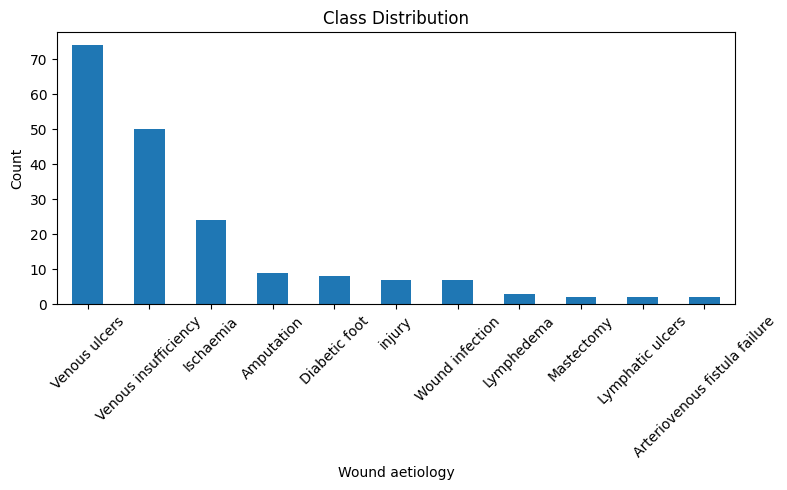

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
from PIL import Image

# Load merged dataset
df = pd.read_csv("/content/drive/MyDrive/wound_project/processed/master_dataset.csv")

# Quick stats
print("📊 Dataset Summary")
print(f"Total samples: {len(df)}")
print(f"Unique patients: {df['patient_id'].nunique() if 'patient_id' in df.columns else 'N/A'}")
print("\nClass distribution:")
print(df['Wound aetiology'].value_counts(dropna=False))

# Missing files check
missing_files = [f for f in df['Absolute path'].dropna().tolist() if not os.path.exists(f)]
print(f"\nMissing files: {len(missing_files)}")

# Plot class distribution
plt.figure(figsize=(8,5))
df['Wound aetiology'].value_counts().plot(kind='bar')
plt.title("Class Distribution")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Show random samples
sample_paths = df['Absolute path'].dropna().tolist()
random_samples = random.sample(sample_paths, min(3, len(sample_paths)))

for img_path in random_samples:
    if os.path.exists(img_path):
        img = Image.open(img_path)
        plt.imshow(img)
        plt.axis("off")
        label = df.loc[df['Absolute path'] == img_path, 'Wound aetiology'].values[0]
        plt.title(f"Label: {label}")
        plt.show()

In [85]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from glob import glob

# ===== SETTINGS =====
INPUT_DIR = "raw_dataset"      # root folder with images (can have subfolders)
OUTPUT_DIR = "processed_dataset"
TARGET_SIZE = (224, 224)       # width, height
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
USE_IMAGENET_NORM = True       # True = use pretrained model normalization

os.makedirs(OUTPUT_DIR, exist_ok=True)

# ===== FUNCTION: Resize with padding =====
def resize_with_padding(image, target_size=TARGET_SIZE):
    h, w = image.shape[:2]
    scale = min(target_size[0] / h, target_size[1] / w)
    new_w, new_h = int(w * scale), int(h * scale)
    resized = cv2.resize(image, (new_w, new_h))
    top = (target_size[1] - new_h) // 2
    bottom = target_size[1] - new_h - top
    left = (target_size[0] - new_w) // 2
    right = target_size[0] - new_w - left
    return cv2.copyMakeBorder(resized, top, bottom, left, right,
                              cv2.BORDER_CONSTANT, value=[0, 0, 0])

# ===== FUNCTION: Normalize =====
def normalize_image(image, use_imagenet=True):
    image = image.astype(np.float32) / 255.0
    if use_imagenet:
        mean = np.array(IMAGENET_MEAN, dtype=np.float32)
        std = np.array(IMAGENET_STD, dtype=np.float32)
        image = (image - mean) / std
    return image

# ===== GET ALL IMAGE FILES (recursive) =====
valid_exts = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp")
image_paths = [
    f for f in glob(os.path.join(INPUT_DIR, "**", "*"), recursive=True)
    if f.lower().endswith(valid_exts)
]

if not image_paths:
    print(f"⚠️ No images found in '{INPUT_DIR}' (checked subfolders too).")
else:
    print(f"📸 Found {len(image_paths)} images in '{INPUT_DIR}'.")

# ===== PROCESSING LOOP =====
for img_path in tqdm(image_paths, desc="Processing images"):
    img = cv2.imread(img_path)
    if img is None:
        print(f"[WARNING] Could not read {img_path}")
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Step 1: Resize
    img = resize_with_padding(img, TARGET_SIZE)

    # Step 2: Normalize
    img = normalize_image(img, USE_IMAGENET_NORM)

    # Step 3: Save (de-normalized for viewing)
    save_img = (np.clip(img, 0, 1) * 255).astype(np.uint8)
    rel_path = os.path.relpath(img_path, INPUT_DIR)  # keep subfolder structure
    save_path = os.path.join(OUTPUT_DIR, rel_path)
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    cv2.imwrite(save_path, cv2.cvtColor(save_img, cv2.COLOR_RGB2BGR))

if image_paths:
    print(f"✅ Processing complete. Saved to '{OUTPUT_DIR}'")


📸 Found 78 images in 'raw_dataset'.


Processing images: 100%|██████████| 78/78 [00:00<00:00, 444.65it/s]

✅ Processing complete. Saved to 'processed_dataset'


📸 Found 78 images in 'raw_dataset' (including subfolders).


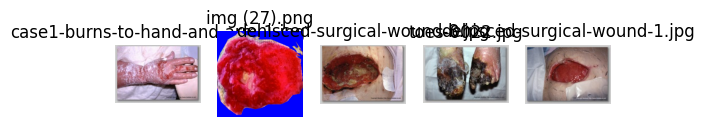

In [86]:
import os
import random
import cv2
from glob import glob
from matplotlib import pyplot as plt

# ===== SETTINGS =====
INPUT_DIR = "raw_dataset"  # change if needed
valid_exts = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp")
NUM_PREVIEWS = 5  # number of random images to preview

# ===== FIND ALL IMAGES =====
image_paths = [
    f for f in glob(os.path.join(INPUT_DIR, "**", "*"), recursive=True)
    if f.lower().endswith(valid_exts)
]

if not image_paths:
    print(f"⚠️ No images found in '{INPUT_DIR}'. Check path or extensions.")
else:
    print(f"📸 Found {len(image_paths)} images in '{INPUT_DIR}' (including subfolders).")

    # ===== SHOW RANDOM SAMPLE IMAGES =====
    sample_paths = random.sample(image_paths, min(NUM_PREVIEWS, len(image_paths)))
    for i, img_path in enumerate(sample_paths, 1):
        img = cv2.imread(img_path)
        if img is None:
            print(f"[WARNING] Cannot read {img_path}")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, NUM_PREVIEWS, i)
        plt.imshow(img)
        plt.title(os.path.basename(img_path))
        plt.axis('off')
    plt.show()


In [87]:
from tqdm import tqdm
from PIL import Image
import os

input_dir = "raw_dataset"
output_dir = "processed_dataset"
os.makedirs(output_dir, exist_ok=True)

# Map your current folders
categories = ["burn", "cuts_infection", "necrosis", "tissue_wound"]

for category in categories:
    category_path = os.path.join(input_dir, category)
    for img_name in tqdm(os.listdir(category_path), desc=f"Processing {category}"):
        img_path = os.path.join(category_path, img_name)
        try:
            img = Image.open(img_path).convert("RGB")
            img = img.resize((224, 224))  # adjust to your model input
            save_path = os.path.join(output_dir, f"{category}_{img_name}")
            img.save(save_path)
        except:
            print(f"⚠️ Could not process {img_path}")


Processing tissue_wound: 100%|██████████| 11/11 [00:00<00:00, 77.53it/s]


In [ ]:

import zipfile

with zipfile.ZipFile("raw_dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("./")  # This will create ./raw_dataset


In [ ]:
from google.colab import files
uploaded = files.upload()


In [88]:
import os

for root, dirs, files in os.walk("raw_dataset"):
    print(root, "->", len(files), "files")


raw_dataset -> 0 files
raw_dataset/burn -> 19 files
raw_dataset/tissue_wound -> 11 files
raw_dataset/necrosis -> 36 files
raw_dataset/cuts_infection -> 12 files


In [89]:
import os
import shutil
import random
from PIL import Image
from tqdm import tqdm

# -----------------------------
# Paths
# -----------------------------
input_dir = "processed_dataset"  # your preprocessed images
output_dir = "dataset"           # final split dataset
categories = ["burn", "cuts_infection", "necrosis", "tissue_wound"]

# -----------------------------
# Split ratios
# -----------------------------
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# -----------------------------
# Create folder structure
# -----------------------------
for split in ["train", "val", "test"]:
    for category in categories:
        os.makedirs(os.path.join(output_dir, split, category), exist_ok=True)

# -----------------------------
# Shuffle and split
# -----------------------------
for category in categories:
    # List files only, not directories
    files = [f for f in os.listdir(os.path.join(input_dir)) if os.path.isfile(os.path.join(input_dir, f)) and f.startswith(category)]
    random.shuffle(files)
    n_total = len(files)
    n_train = int(train_ratio * n_total)
    n_val = int(val_ratio * n_total)

    train_files = files[:n_train]
    val_files = files[n_train:n_train+n_val]
    test_files = files[n_train+n_val:]

    for f in train_files:
        shutil.copy(os.path.join(input_dir, f), os.path.join(output_dir, "train", category, f))
    for f in val_files:
        shutil.copy(os.path.join(input_dir, f), os.path.join(output_dir, "val", category, f))
    for f in test_files:
        shutil.copy(os.path.join(input_dir, f), os.path.join(output_dir, "test", category, f))

print("✅ Dataset split complete!")

✅ Dataset split complete!


In [90]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

# -----------------------------
# Augmentation settings
# -----------------------------
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8,1.2]
)

categories = ["burn", "cuts_infection", "necrosis", "tissue_wound"]
train_dir = "dataset/train"

# -----------------------------
# Loop through each category
# -----------------------------
for category in categories:
    category_path = os.path.join(train_dir, category)
    print(f"🔹 Augmenting category: {category}")

    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        try:
            img = Image.open(img_path)
            img = img.resize((224,224))
            img_array = np.array(img)
            img_array = img_array.reshape((1,)+img_array.shape)

            # Generate 5 augmented images per original
            i = 0
            for batch in datagen.flow(img_array, batch_size=1, save_to_dir=category_path, save_prefix="aug", save_format="jpg"):
                i += 1
                if i >= 5:
                    break
        except:
            print(f"⚠️ Could not process {img_path}")

print("✅ Bulk augmentation complete!")


🔹 Augmenting category: burn
🔹 Augmenting category: cuts_infection
🔹 Augmenting category: necrosis
🔹 Augmenting category: tissue_wound
✅ Bulk augmentation complete!


In [91]:
!pip install torch torchvision tqdm


In [92]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# -----------------------------
# Image transforms
# -----------------------------
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor()
])

val_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

# -----------------------------
# Dataset paths
# -----------------------------
train_dir = "dataset/train"
val_dir = "dataset/val"

# -----------------------------
# Load datasets
# -----------------------------
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

classes = train_dataset.classes
print("Classes:", classes)


Classes: ['burn', 'cuts_infection', 'necrosis', 'tissue_wound']


In [96]:
import torch.nn as nn
import torch.nn.functional as F

class ScarLordCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(ScarLordCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(128*28*28, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128*28*28)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ScarLordCNN(num_classes=4).to(device)


In [94]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [97]:
epochs = 10

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    val_acc = 100 * val_correct / val_total

    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {running_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")


Epoch [1/10] - Loss: 13.9661, Train Acc: 12.62%, Val Acc: 14.29%
Epoch [2/10] - Loss: 13.9676, Train Acc: 12.93%, Val Acc: 14.29%
Epoch [3/10] - Loss: 13.9675, Train Acc: 13.88%, Val Acc: 14.29%
Epoch [4/10] - Loss: 13.9646, Train Acc: 12.93%, Val Acc: 14.29%
Epoch [5/10] - Loss: 13.9695, Train Acc: 12.93%, Val Acc: 14.29%
Epoch [6/10] - Loss: 13.9751, Train Acc: 11.36%, Val Acc: 14.29%
Epoch [7/10] - Loss: 13.9724, Train Acc: 11.04%, Val Acc: 14.29%
Epoch [8/10] - Loss: 13.9608, Train Acc: 12.62%, Val Acc: 14.29%
Epoch [9/10] - Loss: 13.9619, Train Acc: 12.93%, Val Acc: 14.29%
Epoch [10/10] - Loss: 13.9653, Train Acc: 13.56%, Val Acc: 14.29%


In [98]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

test_dir = "dataset/test"
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

classes = test_dataset.classes


✅ Dataset split complete!
Classes: ['burn', 'cuts_infection', 'necrosis', 'tissue_wound']  | Device: cuda
Epoch [1/6] - Loss: 4.6693, Train Acc: 76.66%, Val Acc: 78.57%
Epoch [2/6] - Loss: 0.2386, Train Acc: 100.00%, Val Acc: 85.71%
Epoch [3/6] - Loss: 0.0506, Train Acc: 100.00%, Val Acc: 92.86%
Epoch [4/6] - Loss: 0.0271, Train Acc: 100.00%, Val Acc: 100.00%
Epoch [5/6] - Loss: 0.0443, Train Acc: 100.00%, Val Acc: 100.00%
Epoch [6/6] - Loss: 0.1031, Train Acc: 99.68%, Val Acc: 78.57%


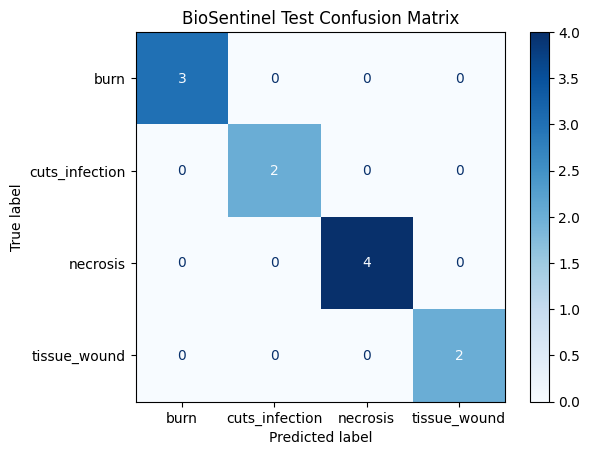

✅ Test Accuracy: 100.00%


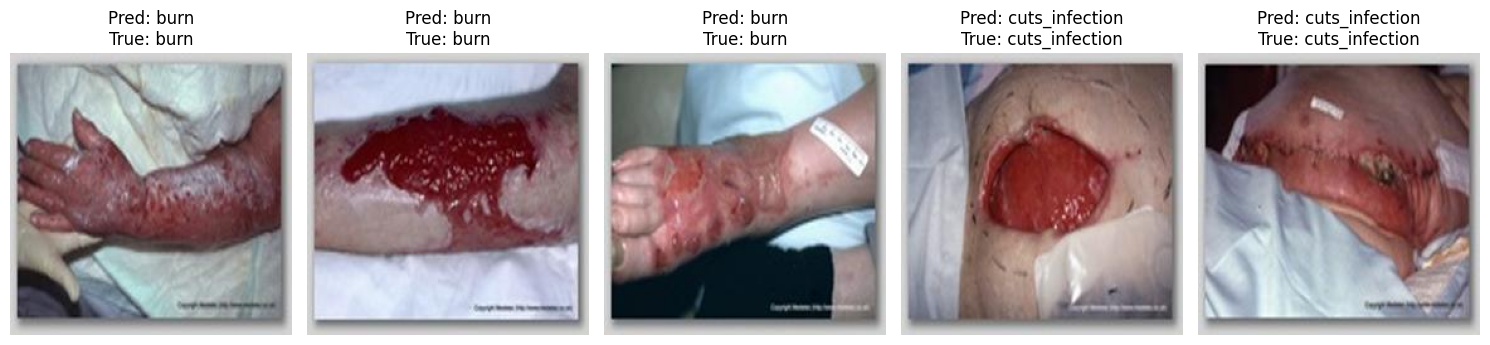

✅ BioSentinel fine-tuned for necrosis detection!


In [99]:
# -----------------------------
# 0️⃣ Imports
# -----------------------------
import os, random, shutil
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# -----------------------------
# 1️⃣ Dataset Split (if not already done)
# -----------------------------
input_dir = "processed_dataset"
output_dir = "dataset"
categories = ["burn", "cuts_infection", "necrosis", "tissue_wound"]

train_ratio, val_ratio, test_ratio = 0.7, 0.2, 0.1

for split in ["train","val","test"]:
    for cat in categories:
        os.makedirs(os.path.join(output_dir, split, cat), exist_ok=True)

for cat in categories:
    cat_input_dir = os.path.join(input_dir, cat)
    if not os.path.exists(cat_input_dir):
        continue
    files = [f for f in os.listdir(cat_input_dir) if os.path.isfile(os.path.join(cat_input_dir, f))]
    random.shuffle(files)
    n_total = len(files)
    n_train = int(train_ratio*n_total)
    n_val = int(val_ratio*n_total)
    splits = {
        "train": files[:n_train],
        "val": files[n_train:n_train+n_val],
        "test": files[n_train+n_val:]
    }
    for split_name, split_files in splits.items():
        for f in split_files:
            shutil.copy(os.path.join(cat_input_dir,f), os.path.join(output_dir,split_name,cat,f))

print("✅ Dataset split complete!")

# -----------------------------
# 2️⃣ Transforms & DataLoaders
# -----------------------------
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

val_transforms   = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

test_transforms  = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(os.path.join(output_dir,"train"), transform=train_transforms)
val_dataset   = datasets.ImageFolder(os.path.join(output_dir,"val"), transform=val_transforms)
test_dataset  = datasets.ImageFolder(os.path.join(output_dir,"test"), transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)

classes = train_dataset.classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Classes:", classes, " | Device:", device)

# -----------------------------
# 3️⃣ ResNet18 Model (Better Fine-tuning)
# -----------------------------
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)  # pretrained for better feature extraction
model.fc = nn.Linear(model.fc.in_features, len(classes))
model = model.to(device)

# Freeze only first half of layers
for name, param in list(model.named_parameters())[:20]:
    param.requires_grad = False

# Weighted loss for imbalance
train_counts = [len(os.listdir(os.path.join(output_dir,"train",c))) for c in categories]
weights = torch.tensor([sum(train_counts)/c for c in train_counts], device=device, dtype=torch.float)
criterion = nn.CrossEntropyLoss(weight=weights)

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0003)

# -----------------------------
# 4️⃣ Training Loop
# -----------------------------
epochs = 6
for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0,0,0
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs,1)
        total += labels.size(0)
        correct += (preds==labels).sum().item()

    train_acc = 100*correct/total

    # Validation
    model.eval()
    val_correct,val_total=0,0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs,1)
            val_total += labels.size(0)
            val_correct += (preds==labels).sum().item()
    val_acc = 100*val_correct/val_total
    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {running_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

# -----------------------------
# 5️⃣ Test Evaluation
# -----------------------------
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs,1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
ConfusionMatrixDisplay(cm, display_labels=classes).plot(cmap=plt.cm.Blues)
plt.title("BioSentinel Test Confusion Matrix")
plt.show()

accuracy = np.sum(np.array(all_preds)==np.array(all_labels))/len(all_labels)*100
print(f"✅ Test Accuracy: {accuracy:.2f}%")

# -----------------------------
# 6️⃣ Sample Predictions Visualization
# -----------------------------
def imshow(img,title):
    npimg = img.numpy().transpose((1,2,0))
    plt.imshow(npimg)
    plt.title(title)
    plt.axis('off')

dataiter = iter(test_loader)
images, labels = next(dataiter)
outputs = model(images.to(device))
_, preds = torch.max(outputs,1)

plt.figure(figsize=(15,5))
for i in range(min(len(images),5)):
    plt.subplot(1,5,i+1)
    imshow(images[i].cpu(), f"Pred: {classes[preds[i]]}\nTrue: {classes[labels[i]]}")
plt.tight_layout()
plt.show()

# Save model
torch.save(model.state_dict(), "BioSentinel_resnet18_fast.pth")
print("✅ BioSentinel fine-tuned for necrosis detection!")


PHASE 2B:Pipeline

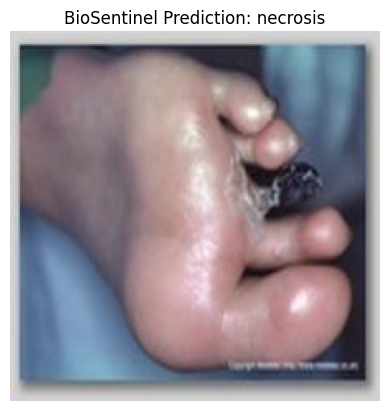

Predicted Class for necrosis_toes-0007.jpg: necrosis


In [100]:
import torch
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import os # Import os to list directory contents
import random # Import random to pick a file

# -----------------------------
# 1️⃣ Setup Model & Device
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classes = ["burn", "cuts_infection", "necrosis", "tissue_wound"]

model = models.resnet18(weights=None) # Use weights=None as the model was trained without pretrained weights initially
model.fc = torch.nn.Linear(model.fc.in_features, len(classes))
model.load_state_dict(torch.load("BioSentinel_resnet18_fast.pth", map_location=device))
model = model.to(device)
model.eval()

# -----------------------------
# 2️⃣ Image Preprocessing
# -----------------------------
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

# -----------------------------
# 3️⃣ Inference Function
# -----------------------------
def predict_wound(image_path):
    try:
        img = Image.open(image_path).convert("RGB")
        img_tensor = transform(img).unsqueeze(0).to(device)  # add batch dim
        with torch.no_grad():
            outputs = model(img_tensor)
            _, pred = torch.max(outputs,1)
            predicted_class = classes[pred.item()]

        # Display image with prediction
        plt.imshow(img)
        plt.title(f"BioSentinel Prediction: {predicted_class}")
        plt.axis('off')
        plt.show()
        return predicted_class
    except FileNotFoundError:
        print(f"❌ Error: Image file not found at {image_path}")
        return None
    except Exception as e:
        print(f"❌ Error processing image {image_path}: {e}")
        return None


# -----------------------------
# 4️⃣ Test Example
# -----------------------------
# Replace with a path to an actual image file
test_image_folder = "dataset/test/necrosis" # Example folder
if os.path.exists(test_image_folder):
    image_files = [f for f in os.listdir(test_image_folder) if os.path.isfile(os.path.join(test_image_folder, f))]
    if image_files:
        test_image_path = os.path.join(test_image_folder, random.choice(image_files)) # Pick a random image
        prediction = predict_wound(test_image_path)
        if prediction:
            print(f"Predicted Class for {os.path.basename(test_image_path)}: {prediction}")
    else:
        print(f"⚠️ No image files found in {test_image_folder}")
else:
    print(f"❌ Test image folder not found: {test_image_folder}")

✅ Model loaded successfully from BioSentinel_resnet18_fast.pth
burn_case5-burn-to-foot.jpg → Predicted: necrosis


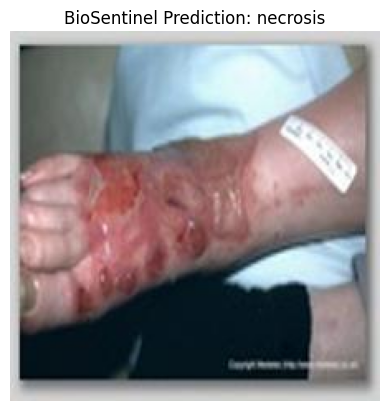

burn_case2-burn-to-arm-2.jpg → Predicted: burn


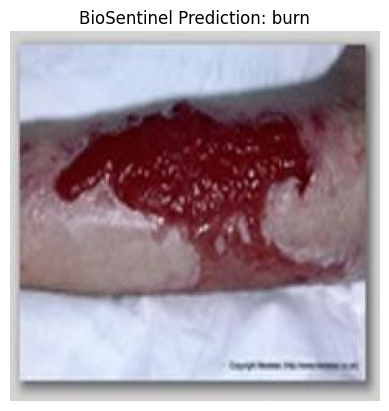

burn_case1-burns-to-hand-and-arm.jpg → Predicted: burn


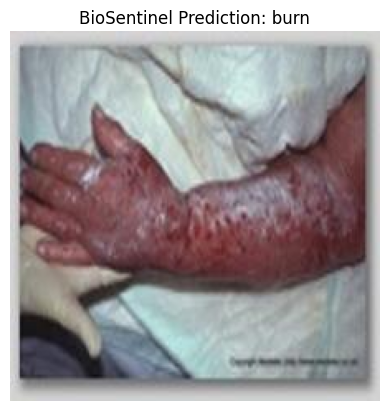


Batch predictions completed for folder: dataset/test/burn
Predictions: ['necrosis', 'burn', 'burn']


In [101]:
import os
import torch
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt

# -----------------------------
# 1️⃣ Setup Model
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classes = ["burn", "cuts_infection", "necrosis", "tissue_wound"]

# Load the trained model (assuming it was saved as 'scarlord_resnet18_fast.pth' or similar)
# Make sure the model architecture matches the saved model
model = models.resnet18(weights=None) # Use weights=None if trained from scratch
model.fc = torch.nn.Linear(model.fc.in_features, len(classes))
# Check if the model state dict file exists before loading
model_path = "BioSentinel_resnet18_fast.pth" # Assuming this is the correct filename from previous successful training
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    print(f"✅ Model loaded successfully from {model_path}")
else:
    print(f"❌ Model file not found at {model_path}. Please ensure the trained model is saved.")
    # You might want to exit or handle this case appropriately
    exit()

model = model.to(device)
model.eval()

# -----------------------------
# 2️⃣ Preprocessing Transform
# -----------------------------
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

# -----------------------------
# 3️⃣ Batch Inference Function
# -----------------------------
def batch_predict(folder_path, show_images=True):
    images_list, paths = [], []

    if not os.path.exists(folder_path):
        print(f"❌ Error: Input folder not found at {folder_path}")
        return

    # Load and preprocess all images
    for img_name in os.listdir(folder_path):
        # Check if the item is a file and has a common image extension
        if os.path.isfile(os.path.join(folder_path, img_name)) and img_name.lower().endswith((".jpg",".png",".jpeg",".bmp",".gif")):
            img_path = os.path.join(folder_path, img_name)
            try:
                img = Image.open(img_path).convert("RGB")
                img_tensor = transform(img)
                images_list.append(img_tensor)
                paths.append(img_path)
            except Exception as e:
                print(f"⚠️ Warning: Could not process image {img_path}: {e}")


    if not images_list:
        print(f"⚠️ No valid images found in folder: {folder_path}")
        return [] # Return empty list if no images processed

    batch_tensor = torch.stack(images_list).to(device)

    with torch.no_grad():
        outputs = model(batch_tensor)
        _, preds = torch.max(outputs,1)

    # Display results
    predictions = []
    for i, img_path in enumerate(paths):
        pred_class = classes[preds[i]]
        predictions.append(pred_class)
        print(f"{os.path.basename(img_path)} → Predicted: {pred_class}")
        if show_images:
            try:
                plt.imshow(Image.open(img_path))
                plt.title(f"BioSentinel Prediction: {pred_class}")
                plt.axis('off')
                plt.show()
            except Exception as e:
                 print(f"⚠️ Warning: Could not display image {img_path}: {e}")


    return predictions

# -----------------------------
# 4️⃣ Example Usage
# -----------------------------
test_folder = "dataset/test/burn"  # Using an existing test class folder for demonstration
predictions = batch_predict(test_folder)
print(f"\nBatch predictions completed for folder: {test_folder}")
print(f"Predictions: {predictions}")

In [102]:
import os
import torch
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# -----------------------------
# 1️⃣ Setup Model
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classes = ["burn", "cuts_infection", "necrosis", "tissue_wound"]

model = models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, len(classes))
model.load_state_dict(torch.load("BioSentinel_resnet18_fast.pth", map_location=device))
model = model.to(device)
model.eval()

# -----------------------------
# 2️⃣ Preprocessing Transform
# -----------------------------
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

# -----------------------------
# 3️⃣ Batch Prediction & Gallery
# -----------------------------
def batch_predict_gallery(folder_path, output_pdf="BioSentinel_predictions.pdf"):
    images_list, paths = [], []

    if not os.path.exists(folder_path):
        print(f"❌ Error: Input folder not found at {folder_path}")
        return

    # Load and preprocess all images
    for img_name in os.listdir(folder_path):
        if img_name.lower().endswith((".jpg",".png",".jpeg")):
            img_path = os.path.join(folder_path, img_name)
            img = Image.open(img_path).convert("RGB")
            images_list.append(transform(img))
            paths.append(img_path)

    if not images_list:
        print("⚠️ No images found in folder!")
        return

    batch_tensor = torch.stack(images_list).to(device)

    with torch.no_grad():
        outputs = model(batch_tensor)
        _, preds = torch.max(outputs,1)

    # Save mini gallery PDF
    with PdfPages(output_pdf) as pdf:
        for i, img_path in enumerate(paths):
            pred_class = classes[preds[i]]
            print(f"{os.path.basename(img_path)} → Predicted: {pred_class}")
            fig, ax = plt.subplots(figsize=(4,4))
            ax.imshow(Image.open(img_path))
            ax.set_title(f"BioSentinel Prediction: {pred_class}")
            ax.axis('off')
            pdf.savefig(fig)
            plt.close(fig)

    print(f"✅ Batch predictions complete! Gallery saved as {output_pdf}")
    return [classes[p.item()] for p in preds]

# -----------------------------
# 4️⃣ Example Usage
# -----------------------------
test_folder = "dataset/test/cuts_infection"  # Corrected path to the test folder
predictions = batch_predict_gallery(test_folder)

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.


cuts_infection_dehisced-surgical-wound-1.jpg → Predicted: cuts_infection
cuts_infection_dehisced-surgical-wound-5.jpg → Predicted: cuts_infection
✅ Batch predictions complete! Gallery saved as BioSentinel_predictions.pdf


2c+2d

In [ ]:
# -----------------------------
# 0️⃣ Imports
# -----------------------------
import os, csv, torch
from torchvision import transforms, models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# -----------------------------
# 1️⃣ Settings
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classes = ["burn", "cuts_infection", "necrosis", "tissue_wound"]
data_dir = "dataset"  # already split train/val/test

# -----------------------------
# 2️⃣ Data Loaders
# -----------------------------
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

test_dataset = ImageFolder(os.path.join(data_dir,"test"), transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
class_names = test_dataset.classes

# -----------------------------
# 3️⃣ Load Pretrained ResNet18
# -----------------------------
model = models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, len(classes))
model.load_state_dict(torch.load("BioSentinel_resnet18_fast.pth", map_location=device))
model = model.to(device)
model.eval()

# -----------------------------
# 4️⃣ Evaluate on Test Set
# -----------------------------
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs,1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix & classification report
cm = confusion_matrix(all_labels, all_preds)
ConfusionMatrixDisplay(cm, display_labels=classes).plot(cmap=plt.cm.Blues)
plt.title("BioSentinel Test Confusion Matrix")
plt.show()

print(classification_report(all_labels, all_preds, target_names=classes))

# -----------------------------
# 5️⃣ Batch Prediction + CSV + PDF Gallery
# -----------------------------
def batch_predict_enhanced(folder_path, output_csv="predictions.csv", output_pdf="predictions.pdf", show_images=False):
    transform = transforms.Compose([transforms.Resize((128,128)), transforms.ToTensor()])
    images_list, paths = [], []

    # Load images
    for img_name in os.listdir(folder_path):
        if img_name.lower().endswith((".jpg",".png",".jpeg")):
            img_path = os.path.join(folder_path, img_name)
            img = Image.open(img_path).convert("RGB")
            images_list.append(transform(img))
            paths.append(img_path)

    if not images_list:
        print("⚠️ No images found")
        return

    batch_tensor = torch.stack(images_list).to(device)
    with torch.no_grad():
        outputs = model(batch_tensor)
        probs = torch.nn.Softmax(dim=1)(outputs)
        _, preds = torch.max(outputs,1)

    # Write CSV
    with open(output_csv, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["filename", "predicted_class", "probability"])
        for i, img_path in enumerate(paths):
            writer.writerow([os.path.basename(img_path), classes[preds[i]], round(probs[i][preds[i]].item(),2)])

    # PDF gallery
    with PdfPages(output_pdf) as pdf:
        for i, img_path in enumerate(paths):
            pred_class = classes[preds[i]]
            prob = probs[i][preds[i]].item()
            if show_images:
                plt.imshow(Image.open(img_path))
                plt.title(f"{pred_class} ({prob:.2f})")
                plt.axis('off')
                pdf.savefig()


In [ ]:
from hashlib import md5

def hash_image(path):
    with open(path, 'rb') as f:
        return md5(f.read()).hexdigest()

train_hashes = set(hash_image(os.path.join(output_dir, "train", c, f))
                   for c in classes
                   for f in os.listdir(os.path.join(output_dir, "train", c)))

overlap = []
for c in classes:
    for f in os.listdir(os.path.join(output_dir, "test", c)):
        h = hash_image(os.path.join(output_dir, "test", c, f))
        if h in train_hashes:
            overlap.append((c, f))

print(f"⚠️ Found {len(overlap)} duplicate test images in training set.")


In [ ]:
# -----------------------------
# 3B: Pretrained ResNet Fine-tuning
# -----------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load pretrained ResNet18
model_ft = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(classes))  # adjust final layer for wound categories
model_ft = model_ft.to(device)

# Freeze earlier layers, train only the last block + FC
for name, param in model_ft.named_parameters():
    if "layer4" not in name and "fc" not in name:
        param.requires_grad = False

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model_ft.parameters()), lr=0.0005)

# Train for a few epochs
epochs = 5
for epoch in range(epochs):
    model_ft.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer_ft.zero_grad()
        outputs = model_ft(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_ft.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    train_acc = 100 * correct / total
    print(f"[3B] Epoch {epoch+1}/{epochs} - Loss: {running_loss:.4f}, Train Acc: {train_acc:.2f}%")

torch.save(model_ft.state_dict(), "resnet18_pretrained_finetuned.pth")
print("✅ 3B complete: Pretrained model saved.")


In [ ]:
# -----------------------------
# 3C: Hyperparameter Tuning
# -----------------------------
from itertools import product

learning_rates = [0.001, 0.0005]
optimizers = ["adam", "sgd"]
batch_sizes = [16, 32]

results = []

for lr, opt_type, bs in product(learning_rates, optimizers, batch_sizes):
    print(f"\n[3C] Testing config: LR={lr}, Optimizer={opt_type}, Batch Size={bs}")

    # Reload model fresh each time
    model_tune = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    model_tune.fc = nn.Linear(model_tune.fc.in_features, len(classes))
    model_tune = model_tune.to(device)

    for name, param in model_tune.named_parameters():
        if "layer4" not in name and "fc" not in name:
            param.requires_grad = False

    criterion = nn.CrossEntropyLoss()
    if opt_type == "adam":
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_tune.parameters()), lr=lr)
    else:
        optimizer = optim.SGD(filter(lambda p: p.requires_grad, model_tune.parameters()), lr=lr, momentum=0.9)

    train_loader_tune = DataLoader(train_dataset, batch_size=bs, shuffle=True)
    val_loader_tune = DataLoader(val_dataset, batch_size=bs, shuffle=False)

    # Quick 2-epoch test for speed
    for epoch in range(2):
        model_tune.train()
        for images, labels in train_loader_tune:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model_tune(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Validation accuracy
    model_tune.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader_tune:
            images, labels = images.to(device), labels.to(device)
            outputs = model_tune(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    acc = 100 * correct / total
    results.append((lr, opt_type, bs, acc))
    print(f"Validation Accuracy: {acc:.2f}%")

# Show best config
best_config = max(results, key=lambda x: x[3])
print("\n✅ Best config:", best_config)


In [ ]:
# -----------------------------
# 3D: Visualization & Logging
# -----------------------------
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Evaluate on test set
model_ft.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_ft(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Test Confusion Matrix")
plt.show()

# Sample Predictions
def imshow(img, title):
    npimg = img.numpy().transpose((1,2,0))
    plt.imshow(npimg)
    plt.title(title)
    plt.axis('off')

dataiter = iter(test_loader)
images, labels = next(dataiter)
outputs = model_ft(images.to(device))
_, preds = torch.max(outputs, 1)

plt.figure(figsize=(15,5))
for i in range(min(len(images), 5)):
    plt.subplot(1,5,i+1)
    imshow(images[i].cpu(), f"Pred: {classes[preds[i]]}\nTrue: {classes[labels[i]]}")
plt.tight_layout()
plt.show()

print("✅ 3D complete: Visualization done.")


In [ ]:
# -----------------------------
# 4A: Final Test Evaluation
# -----------------------------
from sklearn.metrics import classification_report

# Load best model from Phase 3
model_best = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model_best.fc = nn.Linear(model_best.fc.in_features, len(classes))
model_best.load_state_dict(torch.load("resnet18_pretrained_finetuned.pth"))
model_best = model_best.to(device)
model_best.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_best(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("✅ Final Classification Report:")
print(classification_report(all_labels, all_preds, target_names=classes))


In [ ]:
# -----------------------------
# 4B: Error Analysis
# -----------------------------
import matplotlib.pyplot as plt

misclassified_images = []
misclassified_labels = []
misclassified_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_best(images)
        _, preds = torch.max(outputs, 1)
        for i in range(len(labels)):
            if preds[i] != labels[i]:
                misclassified_images.append(images[i].cpu())
                misclassified_labels.append(labels[i].cpu())
                misclassified_preds.append(preds[i].cpu())

# Show some misclassifications
plt.figure(figsize=(15,5))
for i in range(min(5, len(misclassified_images))):
    plt.subplot(1,5,i+1)
    npimg = misclassified_images[i].numpy().transpose((1,2,0))
    plt.imshow(npimg)
    plt.title(f"Pred: {classes[misclassified_preds[i]]}\nTrue: {classes[misclassified_labels[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

print(f"Found {len(misclassified_images)} misclassified samples.")


In [ ]:
# -----------------------------
# 4C: Robustness Check
# -----------------------------
test_aug = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomRotation(10),  # small rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

aug_test_dataset = datasets.ImageFolder(os.path.join(output_dir,"test"), transform=test_aug)
aug_test_loader = DataLoader(aug_test_dataset, batch_size=16, shuffle=False)

all_preds_aug, all_labels_aug = [], []
with torch.no_grad():
    for images, labels in aug_test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_best(images)
        _, preds = torch.max(outputs, 1)
        all_preds_aug.extend(preds.cpu().numpy())
        all_labels_aug.extend(labels.cpu().numpy())

acc_aug = np.sum(np.array(all_preds_aug) == np.array(all_labels_aug)) / len(all_labels_aug) * 100
print(f"✅ Robustness Accuracy with Augmented Test Data: {acc_aug:.2f}%")


In [ ]:
#MobileNet v3
# -----------------------------
# 0️⃣ Imports
# -----------------------------
import os, random, shutil
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# -----------------------------
# 1️⃣ Dataset Paths
# -----------------------------
output_dir = "dataset"  # train/val/test folders already split
categories = ["burn", "cuts_infection", "necrosis", "tissue_wound"]

# -----------------------------
# 2️⃣ Data Transforms & Loaders
# -----------------------------
train_transforms = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])
val_transforms = transforms.Compose([transforms.Resize((128,128)), transforms.ToTensor()])
test_transforms = transforms.Compose([transforms.Resize((128,128)), transforms.ToTensor()])

train_dataset = datasets.ImageFolder(os.path.join(output_dir,"train"), transform=train_transforms)
val_dataset   = datasets.ImageFolder(os.path.join(output_dir,"val"), transform=val_transforms)
test_dataset  = datasets.ImageFolder(os.path.join(output_dir,"test"), transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)

classes = train_dataset.classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Classes:", classes, "| Device:", device)

# -----------------------------
# 3️⃣ MobileNetV3-Small Model
# -----------------------------
model = models.mobilenet_v3_small(weights=None)  # no pretrained weights for speed
model.classifier[3] = nn.Linear(model.classifier[3].in_features, len(classes))
model = model.to(device)

# Freeze features to reduce overfitting & speed up
for param in model.features.parameters():
    param.requires_grad = False

# Weighted loss (in case of class imbalance)
train_counts = [len(os.listdir(os.path.join(output_dir,"train",c))) for c in categories]
weights = torch.tensor([sum(train_counts)/c for c in train_counts], device=device, dtype=torch.float)
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

# -----------------------------
# 4️⃣ Training Loop
# -----------------------------
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    train_acc = 100 * correct / total

    # Validation
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (preds == labels).sum().item()
    val_acc = 100 * val_correct / val_total

    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {running_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

# -----------------------------
# 5️⃣ Test Evaluation
# -----------------------------
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
ConfusionMatrixDisplay(cm, display_labels=classes).plot(cmap=plt.cm.Blues)
plt.title("BioSentinel MobileNetV3-Small Test Confusion Matrix")
plt.show()

accuracy = np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels) * 100
print(f"✅ Test Accuracy: {accuracy:.2f}%")

# -----------------------------
# 6️⃣ Sample Predictions
# -----------------------------
def imshow(img, title):
    npimg = img.numpy().transpose((1,2,0))
    plt.imshow(npimg)
    plt.title(title)
    plt.axis('off')

dataiter = iter(test_loader)
images, labels = next(dataiter)
outputs = model(images.to(device))
_, preds = torch.max(outputs, 1)

plt.figure(figsize=(15,5))
for i in range(min(len(images),5)):
    plt.subplot(1,5,i+1)
    imshow(images[i].cpu(), f"Pred: {classes[preds[i]]}\nTrue: {classes[labels[i]]}")
plt.tight_layout()
plt.show()

# -----------------------------
# 7️⃣ Save Model
# -----------------------------
torch.save(model.state_dict(), "BioSentinel_MobileNetV3Small.pth")
print("✅ BioSentinel MobileNetV3-Small training & evaluation complete!")


In [ ]:
import torch
from torchvision import models

# -----------------------------
# Load trained model
# -----------------------------
classes = ["burn", "cuts_infection", "necrosis", "tissue_wound"]

model = models.mobilenet_v3_small(weights=None)
model.classifier[3] = torch.nn.Linear(model.classifier[3].in_features, len(classes))
model.load_state_dict(torch.load("BioSentinel_MobileNetV3Small.pth", map_location="cpu"))
model.eval()

# -----------------------------
# Apply Dynamic Quantization
# -----------------------------
quantized_model = torch.quantization.quantize_dynamic(
    model, {torch.nn.Linear}, dtype=torch.qint8
)

# Save quantized version
torch.save(quantized_model.state_dict(), "BioSentinel_MobileNetV3Small_quantized.pth")

# Check size difference
import os
orig_size = os.path.getsize("BioSentinel_MobileNetV3Small.pth") / 1024
quant_size = os.path.getsize("BioSentinel_MobileNetV3Small_quantized.pth") / 1024
print(f"Original: {orig_size:.2f} KB | Quantized: {quant_size:.2f} KB")


In [ ]:
#exporting for deployment TORCHSCRIPT+ONNX
#can use this to deploy if you get more datasets to train the model on

# 4d_export.py
import os
import torch
import torch.nn as nn
from torchvision import models

# ---------- config ----------
ARCH = "mobilenetv3_small"   # "mobilenetv3_small" or "resnet18"
NUM_CLASSES = 4
IMG_SIZE = 128               # match your training transforms
PT_PATH = "BioSentinel_MobileNetV3Small.pth"   # or your resnet .pth
TS_PATH = "BioSentinel.torchscript.pt"
ONNX_PATH = "BioSentinel.onnx"
USE_QUANT = False            # set True if you exported a quantized state_dict
# ----------------------------

# Build the model skeleton
if ARCH == "mobilenetv3_small":
    model = models.mobilenet_v3_small(weights=None)
    model.classifier[3] = nn.Linear(model.classifier[3].in_features, NUM_CLASSES)
elif ARCH == "resnet18":
    model = models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
else:
    raise ValueError("Unsupported ARCH")

# Load weights
state = torch.load(PT_PATH, map_location="cpu")
model.load_state_dict(state)
model.eval()

# (Optional) dynamic quantization (linear layers only) before export
if USE_QUANT:
    model = torch.quantization.quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)
    print("Applied dynamic quantization.")

# Dummy input for tracing/export (NCHW)
dummy = torch.randn(1, 3, IMG_SIZE, IMG_SIZE)

# ---------- TorchScript ----------
traced = torch.jit.trace(model, dummy)
traced.save(TS_PATH)
print(f"✅ Saved TorchScript: {TS_PATH} (size: {os.path.getsize(TS_PATH)/1024:.1f} KB)")

# ---------- ONNX ----------
# Note: opset 12+ is generally safe; 17 works well with recent runtimes
torch.onnx.export(
    model,
    dummy,
    ONNX_PATH,
    export_params=True,
    opset_version=17,
    do_constant_folding=True,
    input_names=["input"],
    output_names=["logits"],
    dynamic_axes={"input": {0: "batch"}, "logits": {0: "batch"}},
)
print(f"✅ Saved ONNX: {ONNX_PATH} (size: {os.path.getsize(ONNX_PATH)/1024:.1f} KB)")


In [ ]:
!pip install onnx

In [ ]:
import os

# Create a folder called BioSentinel
os.makedirs("/content/BioSentinel", exist_ok=True)
